1. mnist 데이터를 이용하여:
 - 출력이 (16, 16, 10)인 모델을 함수형 API 모델로 작성하여라.
 - 모델만 작성하여 summary 로 확인할 수 있으면 된다.

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from keras import layers, models

In [2]:
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255

inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(16, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
features = layers.Dense(16, activation="relu")(features)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs, outputs)

model.summary()

11490434/11490434 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 16)                12560     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                              

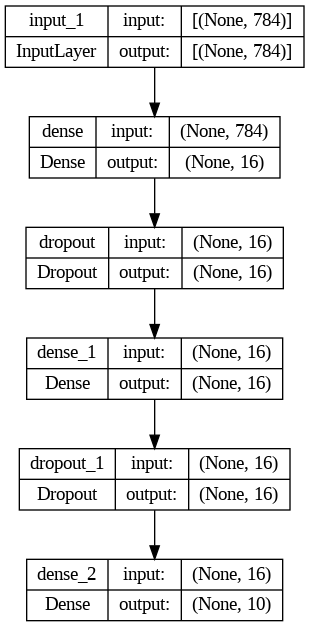

In [3]:
keras.utils.plot_model(model, show_shapes=True)

2. 위 모델로 10 epoch를 학습하는데,
 - 1 epoch 때의 손실과 마지막 epoch 때의 손실의 차이를 print 하는 callback 함수를 작성하자.
 - 10개의 클래스별 정확도를 출력하는 Class_accuracy metric을 정의하고 이를 metrics에 accuracy와 더불어 추가하라.
    - 즉, compile시 metrics 옵션에 ['accuracy', Class_accuracy(10)]을 지정한다.
    - 이때 10은 class의 수이다.

In [4]:
import numpy as np
import tensorflow as tf
y_pred = tf.random.uniform((5,10))
y_pred

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0.15376997, 0.2292726 , 0.5998677 , 0.83862495, 0.7515733 ,
        0.46135855, 0.44625962, 0.98294365, 0.8015065 , 0.37563062],
       [0.95480204, 0.6195018 , 0.21615827, 0.00373912, 0.7193575 ,
        0.6003734 , 0.9239806 , 0.5612359 , 0.8644464 , 0.4659524 ],
       [0.02204347, 0.1775043 , 0.96974695, 0.8160949 , 0.7653849 ,
        0.33837092, 0.17925298, 0.79559183, 0.4359219 , 0.37850642],
       [0.6039424 , 0.9382899 , 0.9191706 , 0.05304527, 0.8665383 ,
        0.74044085, 0.44522822, 0.73313904, 0.02886224, 0.02071345],
       [0.4592924 , 0.54760265, 0.08615756, 0.67014325, 0.7529224 ,
        0.54915476, 0.05548143, 0.80196226, 0.87763965, 0.34278667]],
      dtype=float32)>

In [5]:
y_pred = tf.math.argmax(y_pred, axis=-1)
y_pred

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([7, 0, 2, 1, 8])>

In [6]:
y_pred = y_pred.numpy()

In [7]:
y_pred

array([7, 0, 2, 1, 8])

In [8]:
y_true = np.array([7,0,2,2,8])

In [9]:
y_pred[1]

0

- acc는 각 디짓별로 볓개를 맞추었지를 매 배치마다 저장하는 데이터
- class_samples는 각 디짓별로 실제 값이 몇개 출현했는 지를 담는 리스트

In [10]:
acc = np.zeros((10,))
acc

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
class_samples = np.zeros((10,))
class_samples

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
for i, y in enumerate(y_true):
    # tensor라면 tensor의 일부분(slice)에 대한 assign_add에 버그가 존재함
    class_samples[y] += 1
    if y == y_pred[i]:
        acc[y] += 1

acc, class_samples

(array([1., 0., 1., 0., 0., 0., 0., 1., 1., 0.]),
 array([1., 0., 2., 0., 0., 0., 0., 1., 1., 0.]))

디짓이 0,1,2 만 있다고 할 때:
- 0은 5개 중에서 3개만 맞았고
- 1은 5개 중에서 5개 다 맞았고
- 2는 5개 중에서 4개만 맞았다고 할 때

각 디지의 정확도를 개산하면:

In [14]:
acc = tf.convert_to_tensor(np.array([3,5,4]))
num = tf.convert_to_tensor(np.array([5,5,5]))
print(acc.shape, num.shape)

acc / num

(3,) (3,)


<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.6, 1. , 0.8])>

In [19]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
# tf.compat.v1.enable_eager_execution()

class Class_accuracy(keras.metrics.Metric):

    # 학습 로그에서 보여지는 이름을 name 옵션으로 지정해준다.
    # - acc_sum은 class별 정답의 갯수, class_samples는 class별 실제값의 갯수
    def __init__(self, name="class_accuracy", **kwargs):
        super(Class_accuracy, self).__init__(name=name, **kwargs)
        self.acc_sum = self.add_weight(name="acc_sum", shape=(10,), initializer="zeros")
        self.class_samples = self.add_weight(name="class_samples", initializer="zeros", shape=(10,))

    # tensorflow의 문제 : https://github.com/tensorflow/tensorflow/issues/30468
    # - tensorflow 2.0 variable slice assign_add not supported : v2.9에서 해결되었다고 하나 아직 여전
    # - assign_add 대신 assign으로 문제를 해결했다.
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1).numpy()
        # 아래와 같이 색인을 위해 int 값으로 변환했다.
        y_true = tf.cast(y_true, tf.int32).numpy().reshape((-1,))
        for i, y in enumerate(y_true):
            tmp = self.class_samples.numpy()
            tmp[y] += 1
            self.class_samples.assign(tf.convert_to_tensor(tmp))
            if y == y_pred[i]:
                tmp = self.acc_sum.numpy()
                tmp[y] += 1
                self.acc_sum.assign(tf.convert_to_tensor(tmp))
    
    # - model의 fit 메소드가 매 epoch가 끝날 때 마다 호출하는 on_epoch_end 함수에서 result 메소드를 호출한다.
    # - class별 정답의 갯수를 class 별 맞은 갯수로 나눈다.
    def result(self):
        rst = self.acc_sum / tf.cast(self.class_samples, tf.float32)
        print(rst.numpy())
        return rst

    # - model의 fit 메소드가 매 epoch가 시작할 때 마다 호출하는 on_epoch_begin 함수에서 reset_state 메소드를 호출한다.
    def reset_state(self):
        self.acc_sum.assign(tf.zeros(10,))
        self.class_samples.assign(tf.zeros(10,))

2.9.2


1 epoch 때의 손실과 마지막 epoch 때의 손실의 차이를 print 하는 callback 함수를 작성하자

In [16]:
class LossDifference(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.train_epoch_losses = []
        self.val_epoch_losses = []
        self.is_val = False

    def on_epoch_end(self, epoch, logs):
        loss = logs.get('loss')
        self.train_epoch_losses.append(loss)
        if 'val_loss' in logs.keys():
            loss = logs.get('val_loss')
            self.val_epoch_losses.append(loss)
            self.is_val = True

    def on_train_end(self, logs):
        epochs = len(self.train_epoch_losses)
        train_diff = self.train_epoch_losses[0] - self.train_epoch_losses[-1]
        prt_train = f"train loss is lower with {train_diff} during {epochs} epochs"
        print(prt_train)

        if self.is_val:
            val_diff = self.val_epoch_losses[0] - self.val_epoch_losses[-1]
            prt_val = f"val loss is lower with {val_diff} during {epochs} epochs"
            print(prt_val)

In [20]:
from keras.optimizers import Optimizer
model.compile(
    optimizer='rmsprop',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy', Class_accuracy()], 
    run_eagerly=True
)

In [ ]:
h = model.fit(images, labels, 512, 5, 
              validation_data=(test_images, test_labels),
              callbacks=[LossDifference()])

Epoch 1/5
[0.65       0.77272725 0.3617021  0.5        0.5535714  0.30952382
 0.4814815  0.33333334 0.11538462 0.11538462]
  1/118 [..............................] - ETA: 1:01 - loss: 1.7397 - accuracy: 0.4258 - class_accuracy: 0.4193[0.5543478  0.6764706  0.41346154 0.5217391  0.44554454 0.3258427
 0.53061223 0.37142858 0.11650486 0.22115384]
  2/118 [..............................] - ETA: 54s - loss: 1.7378 - accuracy: 0.4238 - class_accuracy: 0.4177 [0.5466667  0.69072163 0.42767295 0.53103447 0.46206897 0.28244275
 0.55944055 0.38709676 0.12345679 0.21710527]
  3/118 [..............................] - ETA: 55s - loss: 1.7186 - accuracy: 0.4284 - class_accuracy: 0.4228[0.59134614 0.69960475 0.40865386 0.48815167 0.45177665 0.24581006
 0.5891892  0.3883495  0.125      0.21243523]
  4/118 [>.............................] - ETA: 55s - loss: 1.7034 - accuracy: 0.4282 - class_accuracy: 0.4200[0.625      0.72131145 0.41245136 0.48314607 0.44       0.21428572
 0.5869565  0.39922482 0.12830